In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
d=pd.read_csv("/home/akozameh/cmblss/data/datos_blanton.csv",sep=",", names=["M","error_inferior","phi","error_superior"])
print(d)

         M  error_inferior       phi  error_superior
0  -23.183        0.000001  0.000003        0.000006
1  -23.020        0.000003  0.000005        0.000011
2  -22.870        0.000013  0.000017        0.000026
3  -22.698        0.000025  0.000035        0.000044
4  -22.565        0.000058  0.000082        0.000105
5  -22.411        0.000105  0.000122        0.000143
6  -22.248        0.000206  0.000241        0.000281
7  -22.096        0.000290  0.000328        0.000371
8  -21.942        0.000445  0.000504        0.000588
9  -21.793        0.000800  0.000933        0.001024
10 -21.638        0.001121  0.001269        0.001481
11 -21.484        0.001525  0.001725        0.001983
12 -21.311        0.002205  0.002573        0.002823
13 -21.176        0.002908  0.003191        0.003609
14 -21.011        0.003495  0.003834        0.004206
15 -20.857        0.004332  0.005056        0.005546
16 -20.703        0.004896  0.005539        0.006077
17 -20.560        0.005707  0.006456        0.

In [9]:
M=d["M"].values
L=d["phi"].values
error_inf=d["phi"]-d["error_inferior"].values
error_sup=d["error_superior"]-d["phi"].values

<ErrorbarContainer object of 3 artists>

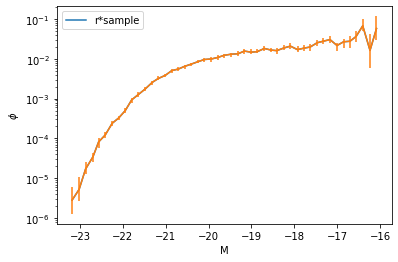

In [10]:
plt.plot(M,L, label="r*sample")
plt.yscale("log")
plt.xlabel("M")
plt.ylabel("$\phi$")
plt.legend()
plt.errorbar(M,L, yerr=[error_inf,error_sup])

In [11]:
# I make the model
def schechter(M, M_s, phi_s, alpha):
    Phi=0.4*np.log(10)*phi_s*10**[-0.4*(M-M_s)]*np.exp[-0.4*(M-M_s)]
    return Phi

In [12]:
# I define the prior
def prior(phi_s, M_s, alpha):
    if 0.0146 <= phi_s <= 0.246 and -20.83 <= M_s<= -19.8  and -2 <= alpha <= -1.20:
        return 1
    else:
        return 0

In [13]:
prior(0.2,-15, 0.1)

0

In [ ]:
# I compute the standard errors
s= (error_sup + error_inf)/2.0       # sigma

In [17]:
# I define the likehood
def likehood(M, L,  M_s,phi_s, alpha,s):
    Phi=schechter(M, M_s, phi_s, alpha)
    # Squared schi
    chi=((L-Phi)/s)**2
    chi_2=np.sum(chi)
    return np.exp(-chi_2/2)

In [19]:
# I define posterior probability
def post(M, L,  M_s,phi_s, alpha,s):
    posteriori=likehood(M, L,  M_s,phi_s, alpha,s)*prior(  M_s,phi_s, alpha)
    return posteriori